In [ ]:
import re, nltk, pandas as pd, numpy as np
from gensim.parsing.porter import PorterStemmer
from sklearn.feature_extraction.text import CountVectorizer
from gensim.parsing.preprocessing import remove_stopwords

In [ ]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [ ]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [ ]:
downloaded = drive.CreateFile({'id':'12CUjW29tTTxYAcPhxuKb_qSn0UTzc4BR'}) # replace the id with id of file you want to access
downloaded.GetContentFile('imdb_sentiment.csv') 

In [ ]:
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
data = pd.read_csv('imdb_sentiment.csv')
data.head()

,review,sentiment
0,"A very, very, very slow-moving, aimless movie ...",0
1,Not sure who was more lost - the flat characte...,0
2,Attempting artiness with black & white and cle...,0
3,Very little music or anything to speak of.,0
4,The best scene in the movie was when Gerardo i...,1




```
# This is formatted as code
```

# Text Cleaning

In [ ]:
stemmer = PorterStemmer()
docs_clean = data['review'].str.lower()
docs_clean = docs_clean.str.replace('-',' ').str.replace('[^\w+\s]', '')   
docs_clean = docs_clean.apply(lambda x : remove_stopwords(x)) # stopword removal
docs_clean = stemmer.stem_documents(docs_clean) # stem documents
docs_clean[:5]

['slow move aimless movi distress drift young man',
 'sure lost flat charact audienc nearli half walk',
 'attempt arti black white clever camera angl movi disappoint ridicul act poor plot line non exist',
 'littl music speak',
 'best scene movi gerardo try song keep run head']

In [ ]:
vectorizer = CountVectorizer(token_pattern='[a-z]{3,10}',
                             min_df=5,
                             stop_words='english').fit(docs_clean) #initiating the fn and fitting the cleaned doc
vocab = vectorizer.get_feature_names() #this fn will be able to identify individual tokens in the doc & extract token names 
print(vocab[:10])
print('length is :',len(vocab))

['absolut', 'act', 'action', 'actor', 'actress', 'actual', 'amaz', 'annoi', 'aphi', 'art']
length is : 246


/usr/local/lib/python3.6/dist-packages/sklearn/feature_extraction/text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['neverthele'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


In [ ]:
dtm = vectorizer.transform(docs_clean)
dtm

<748x246 sparse matrix of type '<class 'numpy.int64'>'
	with 2760 stored elements in Compressed Sparse Row format>

In [ ]:
df_dtm = pd.DataFrame(dtm.toarray(), columns=vocab) # large arrays will throw memory error while converting into dataframes if datasets are bigger
df_dtm.head(10)

,absolut,act,action,actor,actress,actual,amaz,annoi,aphi,art,attempt,audienc,avoid,awai,bad,beauti,begin,believ,best,better,big,bit,black,bore,brilliant,budget,camera,care,cartoon,cast,certainli,charact,cheap,child,cinema,cinematogr,classic,clever,come,comedi,...,strong,stupid,style,subtl,superb,suspens,talent,talk,terribl,thing,think,thought,time,tom,tortur,total,touch,truli,try,turn,understand,unfortun,visual,wai,want,wasnt,wast,watch,white,wonder,wont,word,work,world,wors,worst,worth,write,written,year
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
8,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
9,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


# **Sparsity** -  
* Means more no of zeros as values in the matrix
* Calculated as - No of zeros/No of values

In [ ]:
# Check for no of zeros
df_dtm == 0

,absolut,act,action,actor,actress,actual,amaz,annoi,aphi,art,attempt,audienc,avoid,awai,bad,beauti,begin,believ,best,better,big,bit,black,bore,brilliant,budget,camera,care,cartoon,cast,certainli,charact,cheap,child,cinema,cinematogr,classic,clever,come,comedi,...,strong,stupid,style,subtl,superb,suspens,talent,talk,terribl,thing,think,thought,time,tom,tortur,total,touch,truli,try,turn,understand,unfortun,visual,wai,want,wasnt,wast,watch,white,wonder,wont,word,work,world,wors,worst,worth,write,written,year
0,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,...,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True
1,True,True,True,True,True,True,True,True,True,True,True,False,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,False,True,True,True,True,True,True,True,True,...,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True
2,True,False,True,True,True,True,True,True,True,True,False,True,True,True,True,True,True,True,True,True,True,True,False,True,True,True,False,True,True,True,True,True,True,True,True,True,True,False,True,True,...,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,False,True,True,True,True,True,True,True,True,True,True,True
3,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,...,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True
4,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,False,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,...,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,False,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
743,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,False,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,...,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,False,True,True,True,True,True,True,True,True,True,True,True,True
744,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,...,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,False,True,True,True,True,True,True,True,True,True,True,False,True,True,True,True,True,True,True
745,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,...,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,Tru

In [ ]:
(df_dtm == 0).sum().sum() 

181248

* True : Being zero 
* False : Being non-zero
* (df_dtm == 0).sum() will count no of zeros in columns 
* (df_dtm == 0).sum().sum() will count overall zeros in the matrix


In [ ]:
zeros = (df_dtm == 0).sum().sum() 
non_zeros = (df_dtm.shape[0]*df_dtm.shape[1])-zeros # 
non_zeros

2760

* df_dtm.shape[0] - Rows
* df_dtm.shape[1] - Cols
* Rows * Cols gives total no of values in a matrix

In [ ]:
sparsity = zeros/(df_dtm.shape[0]*df_dtm.shape[1])*100
sparsity

98.50006521455589

* Normally we get sparsity values as above 90% in most cases
* Above we got 98.5% which is very high and shows more no of zeros in the matrix which is also considered as drawbacks of martix

# **Term's Frequency**
* Tells about how much a term has appeared

In [ ]:
df_dtm.sum().head() # returning cols wise sum of terms from the corpus

absolut     9
act        48
action      8
actor      28
actress     6
dtype: int64

In [ ]:
df_dtm.sum().sort_values(ascending=False).head() # Sorting

movi       210
film       189
bad         70
like        60
charact     59
dtype: int64

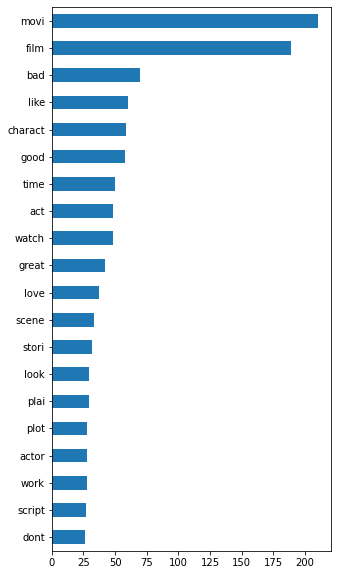

In [ ]:
# Creating a hbar chart to show frequency of words in descending order
df_dtm.sum().sort_values(ascending=False).head(20)[::-1].plot.barh(figsize=(5,10))

# Document Length

In [ ]:
df_dtm.sum(axis=1).head()

0     3
1     3
2    12
3     2
4     5
dtype: int64

Calculating length of document through axis=1, which is row wise sum 


In [ ]:
df_dtm.sum(axis=1).sort_values(ascending=False).head()

136    293
646    183
19     181
149     64
135     51
dtype: int64

In [ ]:
  pd.Series(docs_clean).iloc[136]

'fact hard rememb rai charl act plai man 1 rai charl legendari 1 rai charl life provid excel biograph materi film goe movi musician 1 hitchcock great director 1 iron film total wast time watch 0 secondli hitchcock pretti perfect thriller chase movi 1 pander audienc sabotag film 0 stori lack certain energi 0 plot simpli rumbl like machin desper depend addit new scene 0 usual hitchcock logic flaw 0 mishima extrem uninterest 0 chilli unremark movi author livingwork chilli abstrus cultur 0 flat reenact dont hold attent emotion adrift stagi 0 rest sit aw soldier sing song masculin pledg hairsplit puriti admir sword 0 bore piec kill momentum movi quicker 0 schrader resum lousi amateurish film 0 watch movi 80 love 1 total fascin music danc 1 recent watch thing dvd complet struck extrem stupid storylin contain hole inconsist frankli lot crap horrid danc 0 mean realist world gotten ballet repertori thing pathet 0 charact develop lack depth 0 woa talk aw 0 wast time 0 horribl 0 worst sappiest di

# Vector Representation
* Converting an unstructured information e.g. a word into a structured information which is a vector
* We can perform mathematical operation on a vector

In [ ]:
# Column wise
df_dtm['movi'].to_list()[:20]

[1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 10]

* Above we have extracted the column 'movi' which was a token earlier
* When we extract we get a vector which is a list like structure showing vector representation of the word 'movi'
* This is column wise representation 'where no of values' = 'no of docs'    

In [ ]:
df_dtm['act'].to_list()[:20]

[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0]

In [ ]:
# Row wise
df_dtm.iloc[0].to_list()[:20]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

Above is a vector representation of the first document

# **Term's Distribution analysis**

In [ ]:
term = 'movi'
term_vector = df_dtm[term] # storing it as series

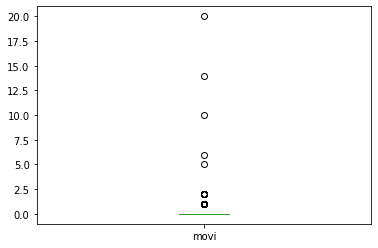

In [ ]:
term_vector.plot.box() # plotting a box plot 

Above shows that the term 'movi' appeared 20 times in one doc, 13 times in another doc and likwise

In [ ]:
 term_vector[term_vector>19] # extracting the term 'movi' in the doc where it appeared 20 times

136    20
Name: movi, dtype: int64

In [ ]:
data.iloc[136]['review'] # Looking at a content of review with index '136' 

' In fact, it\'s hard to remember that the part of Ray Charles is being acted, and not played by the man himself.  \t1\nRay Charles is legendary.  \t1\nRay Charles\' life provided excellent biographical material for the film, which goes well beyond being just another movie about a musician.  \t1\nHitchcock is a great director.  \t1\nIronically I mostly find his films a total waste of time to watch.  \t0\nSecondly, Hitchcock pretty much perfected the thriller and chase movie.  \t1\nIt\'s this pandering to the audience that sabotages most of his films.  \t0\nHence the whole story lacks a certain energy.  \t0\nThe plot simply rumbles on like a machine, desperately depending on the addition of new scenes.  \t0\nThere are the usual Hitchcock logic flaws.  \t0\nMishima is extremely uninteresting.  \t0\nThis is a chilly, unremarkable movie about an author living/working in a chilly abstruse culture.  \t0\nThe flat reenactments don\'t hold your attention because they are emotionally adrift and

In [ ]:
data.iloc[136]['review'].count('movie') # counting no of times term 'movie' appeared in the review at doc with index '136'

20